In [4]:
import pandas as pd

# ===== 配置文件路径 =====
vad_file = "煤炭-挥发分-不同距离\Vad_5mm.xlsx"
mad_file = "煤炭-水分-不同距离\mad_5mm.xlsx"
output_file = "整合数据_1\merged_vad_mad.xlsx"

# ===== 读取数据 =====
df_vad = pd.read_excel(vad_file)
df_mad = pd.read_excel(mad_file)

# 确保列名一致（波长列名必须相同）
if not all(df_vad.columns[2:] == df_mad.columns[2:]):
    raise ValueError("两个文件的光谱列名不一致，请检查波长范围和顺序！")

# 用 Sample 做索引方便对齐
df_vad.set_index("Sample", inplace=True)
df_mad.set_index("Sample", inplace=True)

# 找到两个文件中共有的样本
common_samples = df_vad.index.intersection(df_mad.index)

merged_rows = []
for sample in common_samples:
    vad_row = df_vad.loc[sample]
    mad_row = df_mad.loc[sample]

    # 光谱部分
    vad_spectrum = vad_row.iloc[1:].values  # 从第3列开始是光谱
    mad_spectrum = mad_row.iloc[1:].values

    # 如果光谱完全相同，则合并
    if (vad_spectrum == mad_spectrum).all():
        merged_rows.append({
            "Sample": sample,
            "Vad": vad_row.iloc[0],
            "Mad": mad_row.iloc[0],
            **{col: val for col, val in zip(df_vad.columns[1:], vad_spectrum)}
        })

# 转成 DataFrame
df_merged = pd.DataFrame(merged_rows)

# 保存结果
df_merged.to_excel(output_file, index=False)
print(f"合并完成，共保留 {len(df_merged)} 个样本，结果已保存到 {output_file}")


合并完成，共保留 739 个样本，结果已保存到 整合数据_1\merged_vad_mad.xlsx


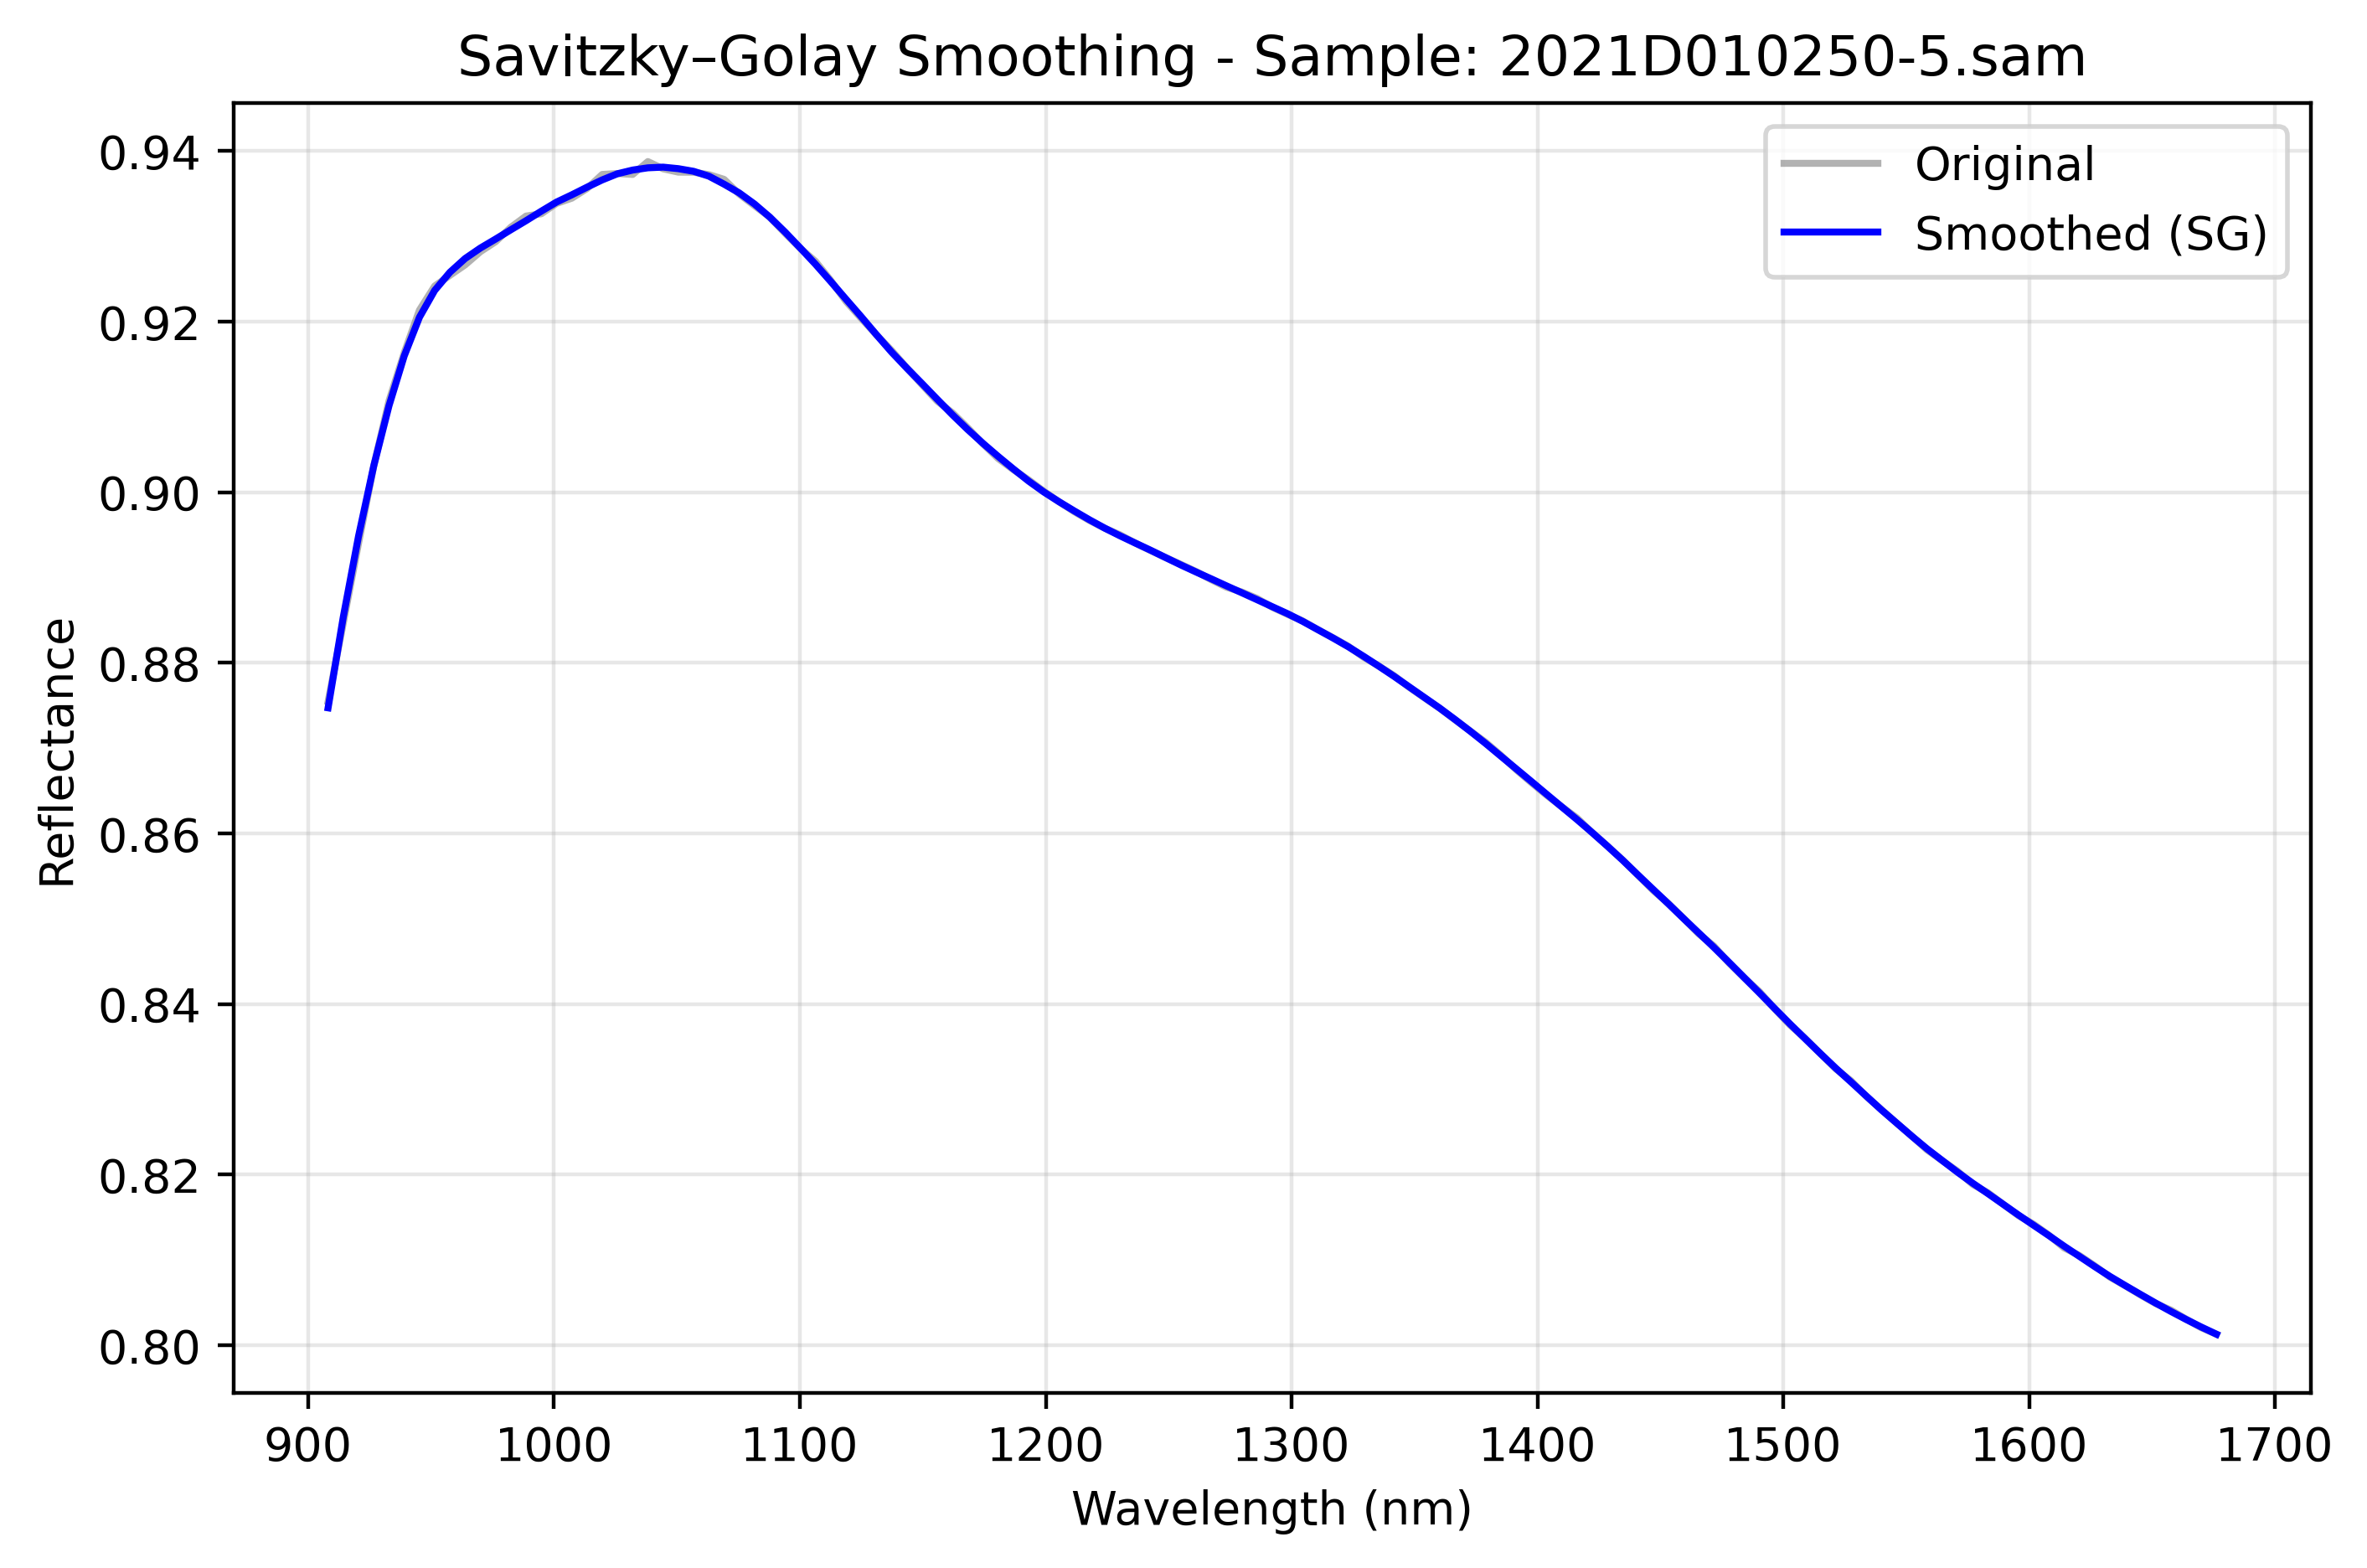

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 1. 读取 Excel
output_file = "整合数据_1\merged_vad_mad.xlsx"
df = pd.read_excel(output_file, sheet_name="Sheet1")

# 2. 提取光谱数据部分（假设第1-3列是 Sample / Vad / Mad）
spectral_df = df.iloc[:, 3:]  
wavelengths = spectral_df.columns.astype(float)  # 波长

# 3. 应用 Savitzky–Golay 平滑滤波器
# window_length 必须是奇数，polyorder 是多项式拟合阶数（常用2或3）
smoothed_spectra = savgol_filter(spectral_df, window_length=11, polyorder=3, axis=1)

# 4. 将平滑后的光谱合并回原表
# df_smoothed = pd.concat([df.iloc[:, :3], pd.DataFrame(smoothed_spectra, columns=spectral_df.columns)], axis=1)
df_smoothed = df

# 5. 绘制一个样本的原始 vs 平滑光谱对比
sample_idx = 0  # 取第1个样本作演示
plt.figure(figsize=(8,5), dpi=400)
plt.plot(wavelengths, spectral_df.iloc[sample_idx], label='Original', color='gray', alpha=0.6)
plt.plot(wavelengths, smoothed_spectra[sample_idx], label='Smoothed (SG)', color='blue')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f"Savitzky–Golay Smoothing - Sample: {df.iloc[sample_idx,0]}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6. 可选择将平滑后的数据保存
df_smoothed.to_excel("整合数据_1\data_smoothed.xlsx", index=False)


In [ ]:
import pandas as pd
from scipy.signal import savgol_filter

# 读取数据
output_file = "整合数据_1\merged_vad_mad.xlsx"
df = pd.read_excel(output_file, sheet_name="Sheet1")

# 假设前三列是 Sample, Vad, Mad，后面都是光谱
spectral_data = df.iloc[:, 3:]  # 光谱部分
wavelengths = spectral_data.columns.astype(float)  # 光谱波长

# SG滤波器参数
window_length = 11  # 必须是奇数，可根据数据分辨率调整
polyorder = 2       # 多项式阶数
deriv_order = 1     # 一阶导数

# 应用 Savitzky–Golay 滤波器，直接求一阶导数
sg_deriv = savgol_filter(
    spectral_data.values, 
    window_length=window_length, 
    polyorder=polyorder, 
    deriv=deriv_order, 
    axis=1
)

# 转成 DataFrame，保留原有信息
# sg_deriv_df = pd.DataFrame(sg_deriv, columns=wavelengths)
# result_df = pd.concat([df.iloc[:, :3], sg_deriv_df], axis=1)

result_df = df

# 保存处理后的结果
result_df.to_excel("整合数据_1\dataset_sg_deriv.xlsx", index=False)

print("SG 滤波 + 一阶导数处理完成，结果已保存到 dataset_sg_deriv.xlsx")


SG 滤波 + 一阶导数处理完成，结果已保存到 dataset_sg_deriv.xlsx


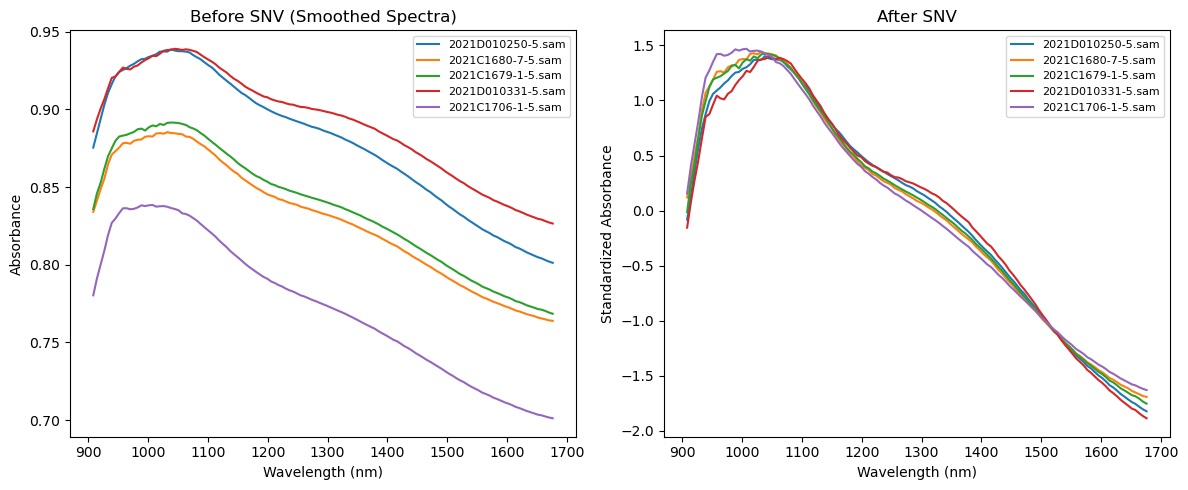

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 df_smoothed 已经完成 Savitzky–Golay 平滑
spectra_cols = df_smoothed.columns[3:]

# 定义 SNV 函数
def snv_transform(row):
    return (row - np.mean(row)) / np.std(row)

# 执行 SNV
df_snv = df_smoothed.copy()
df_snv[spectra_cols] = df_snv[spectra_cols].apply(snv_transform, axis=1)

# 绘制对比（取前 5 个样本）
plt.figure(figsize=(12, 5))

# 原光谱（平滑后）
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(spectra_cols, df_smoothed.iloc[i, 3:], label=df_smoothed.iloc[i, 0])
plt.title("Before SNV (Smoothed Spectra)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.legend(fontsize=8)

# SNV 处理后的光谱
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(spectra_cols, df_snv.iloc[i, 3:], label=df_snv.iloc[i, 0])
plt.title("After SNV")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Standardized Absorbance")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


C:\Users\gorgio\AppData\Local\Temp\ipykernel_12968\542233530.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  wavelengths = pd.Index(spectra_cols).astype(float)  # 用于绘图的横轴


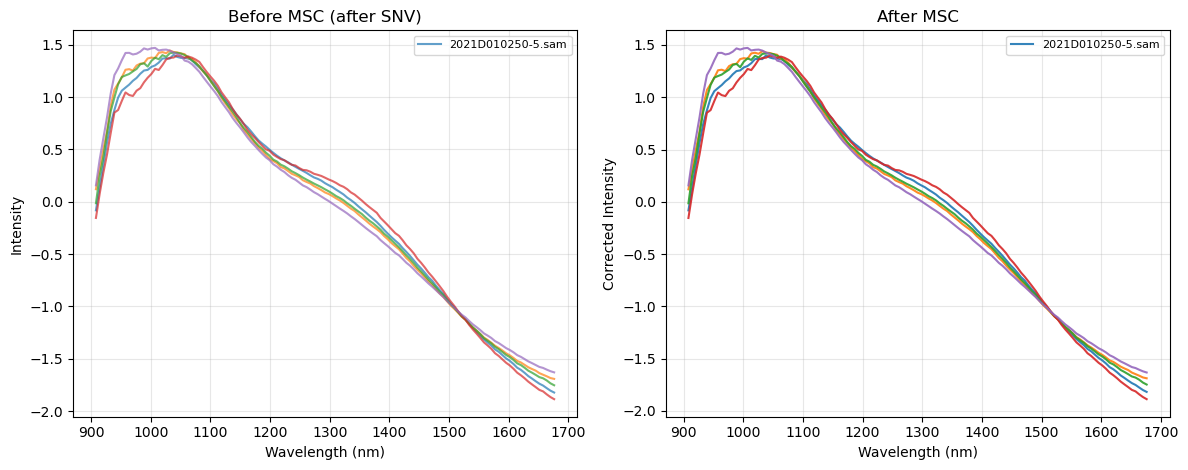

MSC intercept (a) mean±std: -0.0000 ± 0.0000
MSC slope (b)     mean±std: 1.0000 ± 0.0382


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1) 选择光谱列，并构造参考光谱（均值光谱） ===
spectra_cols = df_snv.columns[3:]
wavelengths = pd.Index(spectra_cols).astype(float)  # 用于绘图的横轴
ref = df_snv[spectra_cols].mean(axis=0).values      # 参考光谱（1D，长度=波段数）

# 设计矩阵：y ≈ a*1 + b*ref
A = np.vstack([np.ones_like(ref), ref]).T  # 形状：(n_waves, 2)

# === 2) 对每个样本做 MSC：最小二乘回归得到 a,b，然后 (x-a)/b ===
corrected = np.empty_like(df_snv[spectra_cols].values, dtype=float)
intercepts, slopes = [], []

for i, (_, row) in enumerate(df_snv[spectra_cols].iterrows()):
    y = row.values
    coeffs, *_ = np.linalg.lstsq(A, y, rcond=None)  # 返回 [a, b]
    a, b = coeffs
    intercepts.append(a); slopes.append(b)
    # 数值稳健：避免极小 b 导致除零
    if np.isclose(b, 0.0):
        corr = y - a          # 退化为只做偏移校正
    else:
        corr = (y - a) / b    # MSC 核心
    corrected[i, :] = corr

# === 3) 组装校正后的 DataFrame ===
df_msc = pd.concat(
    [df_snv.iloc[:, :3], pd.DataFrame(corrected, columns=spectra_cols, index=df_snv.index)],
    axis=1
)

# === 4) 可视化：MSC 前后对比（取前 5 个样本） ===
n_show = min(5, len(df_snv))

plt.figure(figsize=(12, 4.8))
# 左：MSC 之前（此处是 SNV 后作为 MSC 的输入）
plt.subplot(1, 2, 1)
for i in range(n_show):
    plt.plot(wavelengths, df_snv.iloc[i, 3:].values,
             alpha=0.7, label=df_snv.iloc[i, 0] if i == 0 else None)
plt.title("Before MSC (after SNV)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.grid(alpha=0.3)
if n_show > 0:
    plt.legend(fontsize=8)

# 右：MSC 之后
plt.subplot(1, 2, 2)
for i in range(n_show):
    plt.plot(wavelengths, df_msc.iloc[i, 3:].values,
             alpha=0.9, label=df_msc.iloc[i, 0] if i == 0 else None)
plt.title("After MSC")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Corrected Intensity")
plt.grid(alpha=0.3)
if n_show > 0:
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# === 5) 可选：保存结果 ===
df_msc.to_excel("整合数据_1/final_data.xlsx", index=False)

# （可选）查看回归系数分布，便于质检
intercepts = np.array(intercepts)
slopes = np.array(slopes)
print(f"MSC intercept (a) mean±std: {intercepts.mean():.4f} ± {intercepts.std():.4f}")
print(f"MSC slope (b)     mean±std: {slopes.mean():.4f} ± {slopes.std():.4f}")


检测到 125 个波长列
光谱数据形状: (739, 125)
正在执行异常检测...

异常检测结果:
Z-score方法 (|Z| > 3): 5 个异常样本
IQR方法: 80 个异常样本
Isolation Forest: 74 个异常样本
Local Outlier Factor: 74 个异常样本

被多种方法检测为异常的样本数: 126

异常样本索引: [  3   4  16  17  18  19  21  22  24  25  26  28  29  30  31  32  33  34
  36  37  38  40  41  44  46  47  48  49  50  51  55  57  60  61  63  64
  65  66  67  71  72  74  77  78  79  80  91  93  96 155 169 171 172 173
 182 187 208 209 215 217 230 241 269 270 271 324 327 328 339 340 341 342
 343 344 364 365 379 383 405 406 410 411 414 415 427 453 454 455 456 457
 458 494 507 508 535 538 539 540 595 607 609 625 629 631 636 642 643 655
 657 666 667 675 680 697 701 702 703 704 705 709 712 715 716 717 720 734]

异常样本数据:
                 Sample      908.1    914.294    920.489    926.683    932.877
3     2021D010331-5.sam  -0.155115   0.073401   0.275147   0.452004   0.656751
4     2021C1706-1-5.sam   0.156708   0.402321   0.605749   0.807898   1.035282
16    2021C1703-5-5.sam  -0.233307  -0.005140   0.218039

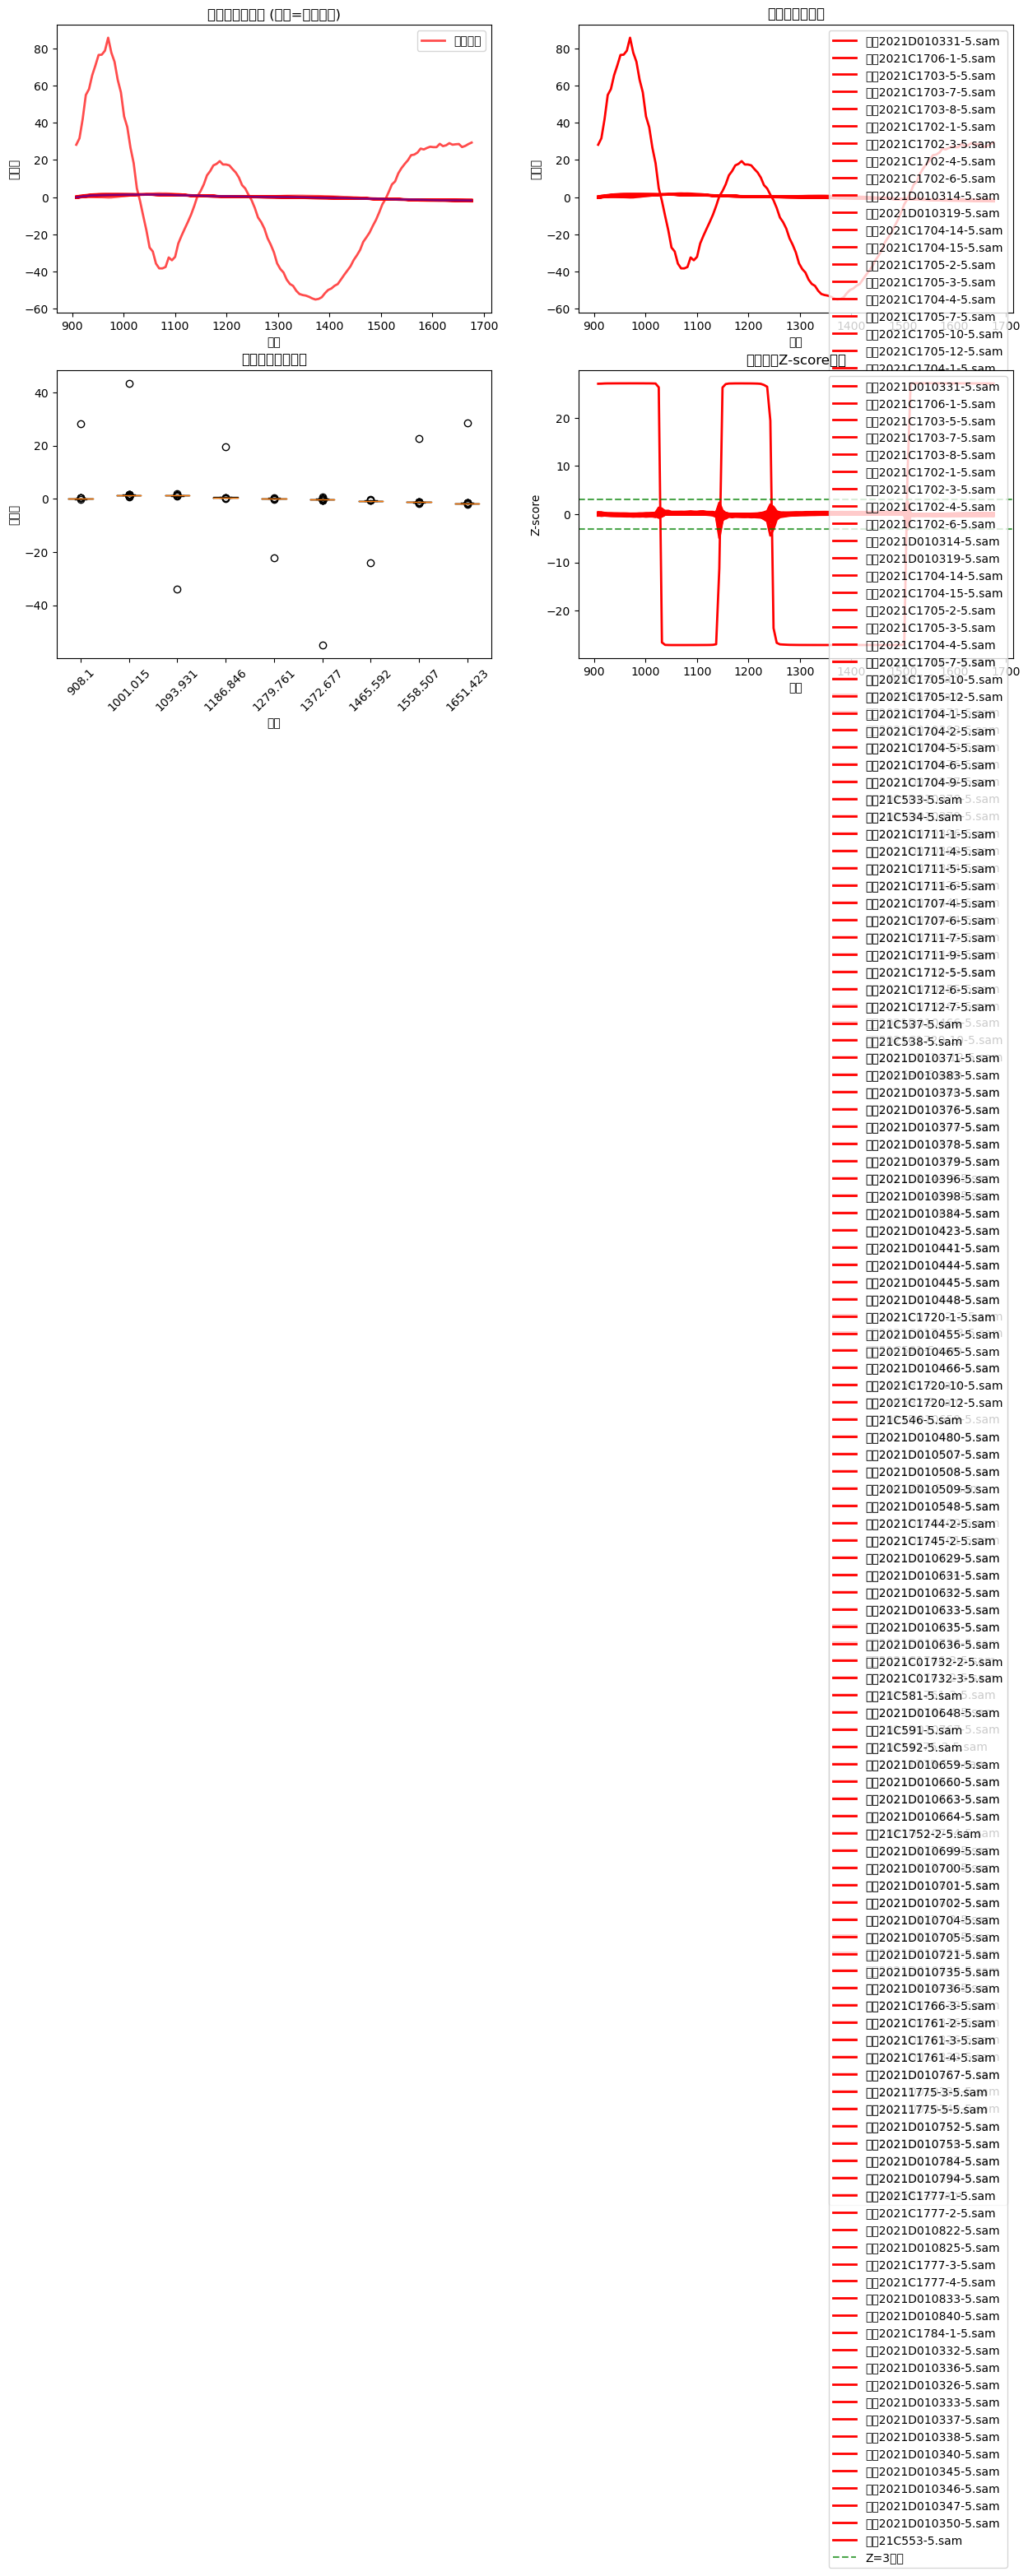


异常样本信息已保存到 '异常样本检测结果.csv'

预处理建议:
1. 删除异常样本: 移除 126 个异常样本
2. 数据清洗后的样本数: 613
3. 可以考虑使用稳健的统计方法或异常值填充方法


In [8]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

# 读取数据
data_path = '整合数据_1/final_data.xlsx'  # 根据您的实际路径调整
df = pd.read_excel(data_path)

# 查找波长列（排除Sample, Vad, Mad等列）
def get_wavelength_cols(df):
    skip_cols = ['Sample', 'Vad', 'Mad', 'VAD', 'MAD']
    wave_cols = []
    for col in df.columns:
        if col not in skip_cols:
            try:
                float(col)
                wave_cols.append(col)
            except:
                continue
    return wave_cols

wave_cols = get_wavelength_cols(df)
print(f"检测到 {len(wave_cols)} 个波长列")

# 准备光谱数据
X = df[wave_cols].values
print(f"光谱数据形状: {X.shape}")

# 方法1: 基于统计的异常检测 (Z-score方法)
def detect_outliers_zscore(X, threshold=3):
    """使用Z-score方法检测异常值"""
    z_scores = np.abs(stats.zscore(X, axis=0))
    outliers = z_scores > threshold
    return outliers

# 方法2: 基于IQR的异常检测
def detect_outliers_iqr(X, factor=1.5):
    """使用IQR方法检测异常值"""
    outliers = np.zeros_like(X, dtype=bool)
    for i in range(X.shape[1]):
        Q1 = np.percentile(X[:, i], 25)
        Q3 = np.percentile(X[:, i], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers[:, i] = (X[:, i] < lower_bound) | (X[:, i] > upper_bound)
    return outliers

# 方法3: 基于Isolation Forest的异常检测
def detect_outliers_isolation(X, contamination=0.1):
    """使用Isolation Forest检测异常值"""
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = iso_forest.fit_predict(X)
    return outlier_labels == -1

# 方法4: 基于Local Outlier Factor的异常检测
def detect_outliers_lof(X, contamination=0.1):
    """使用LOF方法检测异常值"""
    lof = LocalOutlierFactor(contamination=contamination)
    outlier_labels = lof.fit_predict(X)
    return outlier_labels == -1

# 执行异常检测
print("正在执行异常检测...")

# Z-score方法
outliers_zscore = detect_outliers_zscore(X, threshold=3)
outlier_samples_zscore = np.any(outliers_zscore, axis=1)

# IQR方法
outliers_iqr = detect_outliers_iqr(X, factor=1.5)
outlier_samples_iqr = np.any(outliers_iqr, axis=1)

# Isolation Forest方法
outliers_iso = detect_outliers_isolation(X, contamination=0.1)

# LOF方法
outliers_lof = detect_outliers_lof(X, contamination=0.1)

# 统计结果
print(f"\n异常检测结果:")
print(f"Z-score方法 (|Z| > 3): {np.sum(outlier_samples_zscore)} 个异常样本")
print(f"IQR方法: {np.sum(outlier_samples_iqr)} 个异常样本")
print(f"Isolation Forest: {np.sum(outliers_iso)} 个异常样本")
print(f"Local Outlier Factor: {np.sum(outliers_lof)} 个异常样本")

# 找出被多种方法都认为是异常的样本
all_outliers = outlier_samples_zscore | outlier_samples_iqr | outliers_iso | outliers_lof
print(f"\n被多种方法检测为异常的样本数: {np.sum(all_outliers)}")

# 显示异常样本的详细信息
if np.sum(all_outliers) > 0:
    outlier_indices = np.where(all_outliers)[0]
    print(f"\n异常样本索引: {outlier_indices}")
    
    # 显示异常样本的光谱数据
    outlier_data = df.iloc[outlier_indices]
    print(f"\n异常样本数据:")
    print(outlier_data[['Sample'] + wave_cols[:5]].to_string())  # 只显示前5个波长列
    
    # 检查异常样本在哪些波段上异常
    print(f"\n异常样本在各波段的异常情况:")
    for idx in outlier_indices:
        print(f"\n样本 {df.iloc[idx]['Sample']}:")
        for i, col in enumerate(wave_cols):
            if outliers_zscore[idx, i] or outliers_iqr[idx, i]:
                value = X[idx, i]
                mean_val = np.mean(X[:, i])
                std_val = np.std(X[:, i])
                print(f"  波段 {col}: 值={value:.3f}, 均值={mean_val:.3f}, 标准差={std_val:.3f}")

# 可视化异常样本
plt.figure(figsize=(15, 10))

# 1. 所有样本的光谱图，异常样本用红色标记
plt.subplot(2, 2, 1)
for i in range(X.shape[0]):
    if all_outliers[i]:
        plt.plot(wave_cols, X[i, :], 'r-', alpha=0.7, linewidth=2, label='异常样本' if i == outlier_indices[0] else "")
    else:
        plt.plot(wave_cols, X[i, :], 'b-', alpha=0.1)
plt.xlabel('波长')
plt.ylabel('光谱值')
plt.title('所有样本光谱图 (红色=异常样本)')
plt.legend()

# 2. 异常样本的光谱图
plt.subplot(2, 2, 2)
for idx in outlier_indices:
    plt.plot(wave_cols, X[idx, :], 'r-', linewidth=2, label=f'样本{df.iloc[idx]["Sample"]}')
plt.xlabel('波长')
plt.ylabel('光谱值')
plt.title('异常样本光谱图')
plt.legend()

# 3. 箱线图显示异常值分布
plt.subplot(2, 2, 3)
# 选择几个代表性波段进行箱线图分析
selected_waves = wave_cols[::len(wave_cols)//8]  # 选择8个均匀分布的波段
outlier_data_selected = df[['Sample'] + selected_waves]
plt.boxplot([outlier_data_selected[col] for col in selected_waves], labels=selected_waves)
plt.xlabel('波长')
plt.ylabel('光谱值')
plt.title('代表性波段箱线图')
plt.xticks(rotation=45)

# 4. 异常样本在各波段的Z-score
plt.subplot(2, 2, 4)
z_scores = stats.zscore(X, axis=0)
for idx in outlier_indices:
    plt.plot(wave_cols, z_scores[idx, :], 'r-', linewidth=2, label=f'样本{df.iloc[idx]["Sample"]}')
plt.axhline(y=3, color='g', linestyle='--', alpha=0.7, label='Z=3阈值')
plt.axhline(y=-3, color='g', linestyle='--', alpha=0.7)
plt.xlabel('波长')
plt.ylabel('Z-score')
plt.title('异常样本Z-score分布')
plt.legend()

plt.tight_layout()
plt.show()

# 保存异常样本信息
if np.sum(all_outliers) > 0:
    outlier_info = df.iloc[outlier_indices].copy()
    outlier_info['outlier_methods'] = ['; '.join([
        'Z-score' if outlier_samples_zscore[i] else '',
        'IQR' if outlier_samples_iqr[i] else '',
        'IsolationForest' if outliers_iso[i] else '',
        'LOF' if outliers_lof[i] else ''
    ]).strip('; ') for i in outlier_indices]
    
    # 保存到CSV文件
    outlier_info.to_csv('异常样本检测结果.csv', index=False, encoding='utf-8-sig')
    print(f"\n异常样本信息已保存到 '异常样本检测结果.csv'")

# 建议的预处理方法
print(f"\n预处理建议:")
print(f"1. 删除异常样本: 移除 {np.sum(all_outliers)} 个异常样本")
print(f"2. 数据清洗后的样本数: {X.shape[0] - np.sum(all_outliers)}")
print(f"3. 可以考虑使用稳健的统计方法或异常值填充方法")

In [12]:
# 方法1：根据样本名称删除
sample_to_remove = "2021D010350-5.sam"

# 检查样本是否存在
if sample_to_remove in df['Sample'].values:
    print(f"找到样本: {sample_to_remove}")
    
    # 删除该样本
    df_cleaned = df[df['Sample'] != sample_to_remove].reset_index(drop=True)
    
    print(f"删除前样本数: {len(df)}")
    print(f"删除后样本数: {len(df_cleaned)}")
    print(f"成功删除样本: {sample_to_remove}")
    
    # 保存清理后的数据
    df_cleaned.to_excel('整合数据_1/final_data_cleaned.xlsx', index=False)
    print("清理后的数据已保存到 '整合数据_1/final_data_cleaned.xlsx'")
    
else:
    print(f"未找到样本: {sample_to_remove}")
    print("请检查样本名称是否正确")

找到样本: 2021D010350-5.sam
删除前样本数: 739
删除后样本数: 738
成功删除样本: 2021D010350-5.sam
清理后的数据已保存到 '整合数据_1/final_data_cleaned.xlsx'


In [10]:
import pandas as pd
import os
from functools import reduce

def merge_importance_files(file_list, output_file):
    """
    合并多个特征重要性 CSV 文件，按第一列波长对齐
    :param file_list: 输入文件路径列表
    :param output_file: 输出文件路径
    """
    dfs = []

    for file in file_list:
        df = pd.read_csv(file)

        # 第一列假设是波长
        wave_col = df.columns[0]

        # 重命名第一列为统一的 "Wavelength"
        df = df.rename(columns={wave_col: "Wavelength"})
        dfs.append(df)

    # 使用 reduce + merge 按 Wavelength 对齐（外连接，保证所有波长都保留）
    merged_df = reduce(lambda left, right: pd.merge(left, right, on="Wavelength", how="outer"), dfs)

    # 按波长排序
    merged_df = merged_df.sort_values("Wavelength").reset_index(drop=True)

    # 保存结果
    merged_df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"合并后的结果已保存到: {output_file}")


# ===== 使用示例 =====
file_list = [
    "ml_outputs_2/Vad/band_importance.csv",    # 例如第一个文件
    "stats_output/Vad/feature_importance_Vad.csv",        # 例如第二个文件
    "pls_vip_outputs_VAD\corr_scores.csv",        # 例如第二个文件
    "pls_vip_outputs_VAD/vip_scores_raw.csv"        # 例如第二个文件
]
output_file = "整合数据_1/merged_Vad.csv"

merge_importance_files(file_list, output_file)


合并后的结果已保存到: 整合数据_1/merged_Vad.csv
